In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px

import pandas_datareader.data as web
import datetime

# Import libraries Keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
start_day = 3
start_month = 1
start_year = 2017
start_date = datetime.datetime(start_year,start_month,start_day)


end_day = 26
end_month = 2
end_year = 2021
end_date = datetime.datetime(end_year,end_month,end_day)

print(start_date,end_date)

2017-01-03 00:00:00 2021-02-26 00:00:00


In [ ]:
# load data
Sanofi_data = web.DataReader("SAN.PA", 'yahoo', start_date, end_date)


In [ ]:
Sanofi_data  = Sanofi_data.rename_axis('Date').reset_index()


In [ ]:
Sanofi_data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-01-03,78.919998,77.900002,78.250000,78.300003,2325991.0,64.504875
1,2017-01-04,78.599998,77.930000,78.290001,78.300003,2371916.0,64.504875
2,2017-01-05,78.660004,77.370003,77.540001,78.269997,2402135.0,64.480156
3,2017-01-06,77.110001,75.529999,77.000000,76.690002,3922003.0,63.178539
4,2017-01-09,77.839996,76.669998,77.010002,77.519997,2248859.0,63.862297


In [ ]:
plt.figure(figsize=(20,10))
px.line(Sanofi_data,x="Date", y="Close")

<Figure size 1440x720 with 0 Axes>

In [ ]:
def train_test_split(base,split_date):
  train = base[base.Date <= split_date]
  test = base[base.Date > split_date]
  print("taille base d'entrainement:",train.shape)
  print("taille base de test:",test.shape)
  return train,test


split_date = datetime.datetime(2021,1,29)
df_train,df_test = train_test_split(Sanofi_data,split_date)

taille base d'entrainement: (1042, 7)
taille base de test: (20, 7)


In [ ]:
# conversion de la feature Close en values pour keras 
train = df_train.iloc[:, 4:5]
training_set = df_train.iloc[:, 4:5].values

# conversion de la feature Close en values pour keras 
test = df_test.iloc[:, 4:5]
testing_set = df_test.iloc[:, 4:5].values

In [ ]:
train.head()

,Close
0,78.300003
1,78.300003
2,78.269997
3,76.690002
4,77.519997


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Creation du train set pour une prévision de la valeur de l'action au jour j 
# basée sur les 60 jours précédents (3 mois) 
X_train = []
y_train = []
# Dans X_train, les 60 jours précédents le jour i
# Dans y_train, le jour i
# training_set_scaled étant une array, il faut ajouter le numéro de colonne, soit 0 
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
# transformation des listes X_train et y_train en array avec numpy    
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape,y_train.shape

((982, 60), (982,))

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## Partie 1 RNN

In [ ]:
# Initialisation RNN avec Sequential()
regressor = Sequential()

# première couche LSTM et régularisation Dropout
# units = nbre de neurones de la couche
# return_sequences=True car dans le réseau on empile plusieurs couches LSTM
# dans input_shape, indication du train set avec le nbre de time steps (60) et le nbre de feature, ici 1 
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))



In [ ]:
# deuxième couche LSTM layer et régularisation Dropout identique couche précédente
# entrées de cette couche = sortie de la couche précédente : input_shape inutile 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# troisième couche LSTM layer et régularisation Dropout
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))


regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))

In [ ]:
# couche de sortie 1 seul neurone
regressor.add(Dense(units = 1))

# Compilation RNN
# optimizer : cf doc Keras adam (ou RMSprop recommandé pour les RNN)
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [ ]:
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

In [ ]:
real_stock_price = testing_set
real_stock_train = y_train

# prédictions du feature Close 
# concaténation des datasets train et test d'origine, au niveau des lignes avec axis = 0 (l'un au dessus de l'autre)
dataset_total = pd.concat((df_train['Close'], df_test['Close']), axis = 0)
# dans inputs on met les 60 jours précédents le jour à prédire et ceci pour tous les jours du mois à prédire :
# transformation en array pour keras
inputs = dataset_total[len(dataset_total) - len(df_test) - 60:].values
# redimensionnement nécessaire du dataset 
inputs = inputs.reshape(-1,1)
# utilisation du meme objet sc utilisée pour l'entrainement
inputs = sc.transform(inputs)

# alimentation du X_test avec les valeurs inputs correspondantes 
X_test = []
y_test = []
# range de 60 à 80 puisque test set de 20 lignes
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(inputs[i, 0])
# transformation en array    
X_test,y_test = np.array(X_test),np.array(y_test)
# redimensionnement en 3 dimensions avec reshape pour obtenir un X_test avec 20 lignes, 60 colonnes et 1 en troisième dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# prévisions avec fonction predict sur le modèle regressor 
predicted_stock_price = regressor.predict(X_test)
prediction_train = regressor.predict(X_train)
# prévisions sur l'échelle d'orignie avec transformation inverse
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
prediction_train = sc.inverse_transform(prediction_train)


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


#print("pour la base train")
#print("le mse est:",mean_squared_error(real_stock_train, prediction_train))


print("Pour la base test")
print("le R2 est:",r2_score(real_stock_price, predicted_stock_price))
print("le mse est:",mean_squared_error(real_stock_price, predicted_stock_price))
print("le rmse est:",np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price)))




Pour la base test
le R2 est: -0.5732793219785894
le mse est: 3.1894315785961225
le rmse est: 1.7858979754163233


In [ ]:
# contruction du data frame resultat
df_predict = pd.DataFrame(predicted_stock_price, columns=["Prediction"],index = df_test.index)
df_true = pd.DataFrame(real_stock_price, columns=["Valeur"],index = df_test.index)
df_result = pd.concat([df_true,df_predict,df_test.Date],axis= 1)
df_result["error"] = df_result["Prediction"] - df_result["Valeur"]

In [ ]:
import plotly.graph_objects as go


# Visu résultats vraies valeurs versus prévisions avec 50 époques
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_result["Date"],y=df_result["Prediction"],name = "Predictions"))
fig.add_trace(go.Scatter(x=df_result["Date"],y=df_result["Valeur"],name = "valeurs"))
fig.show()


In [ ]:
px.scatter(df_result,x="Date" , y="error")

## Partie2

In [ ]:
def build_LSTMcv():
  regressor = Sequential() 
  regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
  regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = 100, return_sequences = True))
  regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = 100, return_sequences = False))
  regressor.add(Dropout(0.2))
  regressor.add(Dense(units = 1))

  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
  regressor.summary()

  return regressor

def build_LSTM(X_train):
  regressor = Sequential() 
  regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
  regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = 100, return_sequences = True))
  regressor.add(Dropout(0.2))
  regressor.add(LSTM(units = 100, return_sequences = False))
  regressor.add(Dropout(0.2))
  regressor.add(Dense(units = 1))

  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
  regressor.summary()

  return regressor


#regressor2 = build_LSTM(X_train)


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 


LSTM_cv = KerasClassifier(build_fn = build_LSTMcv)

parameters = {'batch_size': [16, 32, 64]}
grid_search = GridSearchCV(estimator = LSTM_cv,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 3)
# entrainement 
grid_search = grid_search.fit(X_train, y_train)
# meilleurs résultats 
best_parameters = grid_search.best_params_
best_mse = grid_search.best_score_


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
dropout_70 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_71 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_72 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
dropout_73 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_74 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_75 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_75 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
dropout_76 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_77 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_77 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_78 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_78 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
dropout_79 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_80 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_80 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_81 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_81 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
dropout_82 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_83 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_83 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_84 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_84 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_85 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
dropout_85 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_86 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_86 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_87 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_87 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
dropout_88 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_89 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_90 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_90 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
dropout_91 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_92 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_92 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_93 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_93 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
dropout_94 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_95 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_95 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_96 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_96 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_97 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
dropout_97 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_98 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_99 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_99 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)               

In [ ]:
print("le meilleur paramétres est :",best_parameters)
print("le RMSE:",np.sqrt(-best_mse))

le meilleur paramétres est : {'batch_size': 16}
le RMSE: 0.5259330622992245


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

history = regressor2.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Epoch 1/100
62/62 [==============================] - 8s 132ms/step - loss: 0.0070 - val_loss: 0.0023
Epoch 2/100
62/62 [==============================] - 7s 120ms/step - loss: 0.0063 - val_loss: 0.0024
Epoch 3/100
62/62 [==============================] - 8s 122ms/step - loss: 0.0063 - val_loss: 0.0020
Epoch 4/100
62/62 [==============================] - 8s 121ms/step - loss: 0.0072 - val_loss: 0.0027
Epoch 5/100
62/62 [==============================] - 7s 120ms/step - loss: 0.0055 - val_loss: 0.0024
Epoch 6/100
62/62 [==============================] - 7s 120ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 7/100
62/62 [==============================] - 8s 123ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 8/100
62/62 [==============================] - 7s 118ms/step - loss: 0.0064 - val_loss: 0.0022
Epoch 9/100
62/62 [==============================] - 8s 125ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 10/100
62/62 [==============================] - 8s 126ms/step - loss: 0.0064 - val_lo

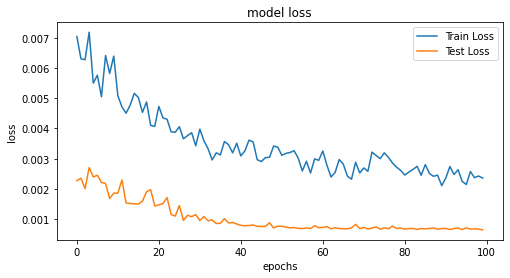

In [222]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
regressor2.fit(X_train,y_train,epochs = 50,batch_size = 16)

In [ ]:
# prévisions avec fonction predict sur le modèle regressor 
predicted_stock_price2 = regressor2.predict(X_test)
# prévisions sur l'échelle d'orignie avec transformation inverse
predicted_stock_price2 = sc.inverse_transform(predicted_stock_price2)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print("le R2 est:",r2_score(real_stock_price, predicted_stock_price2))
print("le mse est:",mean_squared_error(real_stock_price, predicted_stock_price2))

le R2 est: 0.5298591302187226
le mse est: 0.9530933989415644


In [ ]:
# contruction du data frame resultat
df_predict = pd.DataFrame(predicted_stock_price2, columns=["Prediction"],index = df_test.index)
df_true = pd.DataFrame(real_stock_price, columns=["Valeur"],index = df_test.index)
df_result = pd.concat([df_true,df_predict,df_test.Date],axis= 1)
df_result["error"] = df_result["Prediction"] - df_result["Valeur"]

In [ ]:

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_result["Date"],y=df_result["Prediction"],name = "Predictions"))
fig.add_trace(go.Scatter(x=df_result["Date"],y=df_result["Valeur"],name = "valeurs"))
fig.show()

## Partie 3

## Changement de timestep

In [ ]:
def create_train(df_train,step):
  # on inclu une variable step qui sera le nombre de jour qu'on prend pour l'entrainement

  train = df_train.iloc[:, 4:5]
  training_set = df_train.iloc[:, 4:5].values

  sc = MinMaxScaler(feature_range = (0, 1))
  training_set_scaled = sc.fit_transform(training_set)

  X_train = []
  y_train = []
  # Dans X_train, les 60 jours précédents le jour i
  # Dans y_train, le jour i
  # training_set_scaled étant une array, il faut ajouter le numéro de colonne, soit 0 
  for i in range(step, len(training_set)):
      X_train.append(training_set_scaled[i-step:i, 0])
      y_train.append(training_set_scaled[i, 0])
  # transformation des listes X_train et y_train en array avec numpy    
  X_train, y_train = np.array(X_train), np.array(y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  print("X_train shape":X_train.shape)
  return X_train,y_train,sc

def create_test(df_test,df_train,step,sc):
  test = df_test.iloc[:, 4:5]
  testing_set = df_test.iloc[:, 4:5].values

  dataset_total = pd.concat((df_train['Close'], df_test['Close']), axis = 0)
  inputs = dataset_total[len(dataset_total) - len(df_test) - step:].values
  # redimensionnement nécessaire du dataset 
  inputs = inputs.reshape(-1,1)
  # utilisation du meme objet sc utilisée pour l'entrainement
  inputs = sc.transform(inputs)
  X_test = []
  y_test = []
  for i in range(step, step + 20):
      X_test.append(inputs[i-step:i, 0])
      y_test.append(inputs[i, 0])   

  X_test,y_test = np.array(X_test),np.array(y_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  print("X_test shape":X_test.shape)

  return X_test,y_test


X_train3,y_train3,sc3 = create_train(df_train,90)
X_test3,y_test3 = create_test(df_test,df_train,90,sc3)

In [ ]:
regressor3 = build_LSTM(X_train3)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 90, 100)           40800     
_________________________________________________________________
dropout_40 (Dropout)         (None, 90, 100)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 90, 100)           80400     
_________________________________________________________________
dropout_41 (Dropout)         (None, 90, 100)           0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_42 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)               

In [ ]:
X_train3.shape

(952, 90, 1)

In [ ]:
regressor3.fit(X_train3,y_train3, epochs=50, batch_size = 16)

Epoch 1/50
60/60 [==============================] - 11s 185ms/step - loss: 0.0020
Epoch 2/50
60/60 [==============================] - 11s 185ms/step - loss: 0.0022
Epoch 3/50
60/60 [==============================] - 11s 188ms/step - loss: 0.0022
Epoch 4/50
60/60 [==============================] - 11s 186ms/step - loss: 0.0021
Epoch 5/50
60/60 [==============================] - 11s 187ms/step - loss: 0.0021
Epoch 6/50
60/60 [==============================] - 11s 188ms/step - loss: 0.0022
Epoch 7/50
60/60 [==============================] - 11s 190ms/step - loss: 0.0019
Epoch 8/50
60/60 [==============================] - 11s 185ms/step - loss: 0.0022
Epoch 9/50
60/60 [==============================] - 11s 188ms/step - loss: 0.0024
Epoch 10/50
60/60 [==============================] - 11s 187ms/step - loss: 0.0020
Epoch 11/50
60/60 [==============================] - 11s 190ms/step - loss: 0.0021
Epoch 12/50
60/60 [==============================] - 11s 187ms/step - loss: 0.0021
Epoch 13/50
6

In [ ]:
# prévisions avec fonction predict sur le modèle regressor 
predicted_stock_price3 = regressor3.predict(X_test3)
# prévisions sur l'échelle d'orignie avec transformation inverse
predicted_stock_price3 = sc3.inverse_transform(predicted_stock_price3)

print("le R2 est:",r2_score(real_stock_price, predicted_stock_price3))
print("le mse est:",mean_squared_error(real_stock_price, predicted_stock_price3))


# contruction du data frame resultat
df_predict = pd.DataFrame(predicted_stock_price3, columns=["Prediction"],index = df_test.index)
df_true = pd.DataFrame(real_stock_price, columns=["Valeur"],index = df_test.index)
df_result = pd.concat([df_true,df_predict,df_test.Date],axis= 1)
df_result["error"] = df_result["Prediction"] - df_result["Valeur"]


# Visu résultats vraies valeurs versus prévisions avec 50 époques
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_result["Date"],y=df_result["Prediction"],name = "Predictions"))
fig.add_trace(go.Scatter(x=df_result["Date"],y=df_result["Valeur"],name = "valeurs"))
fig.show()


le R2 est: 0.6827611026723497
le mse est: 0.6431227709923405


### Avec un timestep de 30 jours

In [ ]:
X_train4,y_train4,sc4 = create_train(df_train,30)
X_test4,y_test4 = create_test(df_test,df_train,30,sc4)

In [ ]:
regressor4 = build_LSTM(X_train4)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 30, 100)           40800     
_________________________________________________________________
dropout_43 (Dropout)         (None, 30, 100)           0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 30, 100)           80400     
_________________________________________________________________
dropout_44 (Dropout)         (None, 30, 100)           0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_45 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

In [ ]:
regressor4.fit(X_train4,y_train4, epochs=50, batch_size = 16)

Epoch 1/50
64/64 [==============================] - 10s 70ms/step - loss: 0.0590
Epoch 2/50
64/64 [==============================] - 4s 69ms/step - loss: 0.0086
Epoch 3/50
64/64 [==============================] - 4s 70ms/step - loss: 0.0077
Epoch 4/50
64/64 [==============================] - 4s 69ms/step - loss: 0.0077
Epoch 5/50
64/64 [==============================] - 4s 70ms/step - loss: 0.0068
Epoch 6/50
64/64 [==============================] - 4s 70ms/step - loss: 0.0067
Epoch 7/50
64/64 [==============================] - 4s 69ms/step - loss: 0.0058
Epoch 8/50
64/64 [==============================] - 4s 70ms/step - loss: 0.0049
Epoch 9/50
64/64 [==============================] - 4s 69ms/step - loss: 0.0077
Epoch 10/50
64/64 [==============================] - 4s 69ms/step - loss: 0.0048
Epoch 11/50
64/64 [==============================] - 4s 70ms/step - loss: 0.0057
Epoch 12/50
64/64 [==============================] - 4s 70ms/step - loss: 0.0045
Epoch 13/50
64/64 [=================

In [ ]:
# prévisions avec fonction predict sur le modèle regressor 
predicted_stock_price4 = regressor4.predict(X_test4)
# prévisions sur l'échelle d'orignie avec transformation inverse
predicted_stock_price4 = sc4.inverse_transform(predicted_stock_price4)

print("le R2 est:",r2_score(real_stock_price, predicted_stock_price4))
print("le mse est:",mean_squared_error(real_stock_price, predicted_stock_price4))

# contruction du data frame resultat
df_predict = pd.DataFrame(predicted_stock_price4, columns=["Prediction"],index = df_test.index)
df_true = pd.DataFrame(real_stock_price, columns=["Valeur"],index = df_test.index)
df_result = pd.concat([df_true,df_predict,df_test.Date],axis= 1)
df_result["error"] = df_result["Prediction"] - df_result["Valeur"]


# Visu résultats vraies valeurs versus prévisions avec 50 époques
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_result["Date"],y=df_result["Prediction"],name = "Predictions"))
fig.add_trace(go.Scatter(x=df_result["Date"],y=df_result["Valeur"],name = "valeurs"))
fig.show()

le R2 est: 0.6447406955618449
le mse est: 0.7201996672403765


### Volume

In [ ]:
Sanofi_data.head()

In [ ]:
fig = px.scatter(Sanofi_data, x="Volume", y="Close")
fig.show()

### Saisonalité

In [ ]:
Sanofi_data.head(
)

,Date,High,Low,Open,Close,Volume,Adj Close,year,month,week,day_week,day_month,day_year
0,2017-01-03,78.919998,77.900002,78.250000,78.300003,2325991.0,64.504875,2017,1,1,1,3,3
1,2017-01-04,78.599998,77.930000,78.290001,78.300003,2371916.0,64.504875,2017,1,1,2,4,4
2,2017-01-05,78.660004,77.370003,77.540001,78.269997,2402135.0,64.480156,2017,1,1,3,5,5
3,2017-01-06,77.110001,75.529999,77.000000,76.690002,3922003.0,63.178539,2017,1,1,4,6,6
4,2017-01-09,77.839996,76.669998,77.010002,77.519997,2248859.0,63.862297,2017,1,2,0,9,9


In [ ]:
# création de features

Sanofi_data["year"] = Sanofi_data["Date"].dt.year
Sanofi_data["month"] = Sanofi_data["Date"].dt.month
Sanofi_data["week"] = Sanofi_data["Date"].dt.weekofyear
Sanofi_data["day_week"] = Sanofi_data["Date"].dt.dayofweek
Sanofi_data["day_month"] = Sanofi_data["Date"].dt.day
Sanofi_data["day_year"] = Sanofi_data["Date"].dt.dayofyear

Sanofi_data["mean_day"] = 0.25*(Sanofi_data["Open"] + Sanofi_data["Low"] + Sanofi_data["High"] + Sanofi_data["Close"])
Sanofi_data["var_day"] = np.sqrt(0.5*(Sanofi_data["mean_day"] - Sanofi_data["Low"])**2 + (Sanofi_data["mean_day"] - Sanofi_data["High"])**2)

df_var_week = pd.DataFrame(Sanofi_data.groupby(["year","month","week"])["var_day"].agg(mean_var_week ='mean'))
                               
Sanofi_data = Sanofi_data.merge(df_var_week,on=["year","month","week"])
Sanofi_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Date,High,Low,Open,Close,Volume,Adj Close,year,month,week,day_week,day_month,day_year,mean_day,var_day,mean_var_week
0,2017-01-03,78.919998,77.900002,78.250000,78.300003,2325991.0,64.504875,2017,1,1,1,3,3,78.342501,0.656815,0.697115
1,2017-01-04,78.599998,77.930000,78.290001,78.300003,2371916.0,64.504875,2017,1,1,2,4,4,78.280001,0.404535,0.697115
2,2017-01-05,78.660004,77.370003,77.540001,78.269997,2402135.0,64.480156,2017,1,1,3,5,5,77.960001,0.814894,0.697115
3,2017-01-06,77.110001,75.529999,77.000000,76.690002,3922003.0,63.178539,2017,1,1,4,6,6,76.582500,0.912215,0.697115
4,2017-01-09,77.839996,76.669998,77.010002,77.519997,2248859.0,63.862297,2017,1,2,0,9,9,77.259998,0.714456,0.768028


In [ ]:
list_date = ["year","month","week","day_week","day_month","day_year"]
for date in list_date:
  result = pd.DataFrame(Sanofi_data.groupby(date)["Close"].agg("mean")).reset_index()
  fig = px.line(result, x=date, y="Close")
  fig.show()

**on trouve une saisonalité dans les jours du mois tout les 7 jours**



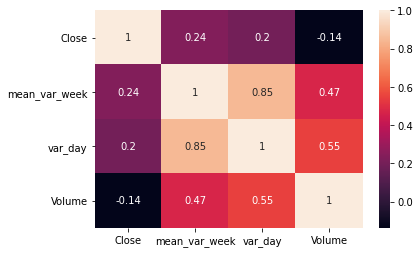

In [ ]:
df_inter = Sanofi_data[["Close","Volume","var_day","mean_var_week"]]

def plot_corrMatrix(df,Nvariable,target):
  corr=df.corr()
  cols = corr.nlargest(20, target)[target].index
  cm = np.corrcoef(df[cols].values.T)
  sns.heatmap(cm,annot=True,yticklabels=cols.values,xticklabels=cols.values)

plot_corrMatrix(df_inter,4,"Close")

### ses variables ne sont pas trés corrélé a la variable target

In [ ]:
df_final = Sanofi_data[["Date","Close","day_month",]]

df_train_2,df_test_2 = train_test_split(df_final,split_date)

df_train_2 = df_train_2.iloc[:,1:]
df_test_2 = df_test_2.iloc[:,1:]

training_set2 = df_train_2.iloc[:,1:].values
testing_set2 = df_test_2.iloc[:,1:].values

taille base d'entrainement: (1042, 3)
taille base de test: (20, 3)


In [ ]:
training_set2 = df_train_2.values

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled2 = sc.fit_transform(training_set2)
training_set_scaled2

array([[0.48552133, 0.06666667],
       [0.48552133, 0.1       ],
       [0.48455588, 0.13333333],
       ...,
       [0.510296  , 0.86666667],
       [0.51093939, 0.9       ],
       [0.44852   , 0.93333333]])

In [ ]:
X_train5 = []
y_train5 = []
for i in range(90, len(training_set2)):
    X_train5.append(training_set_scaled2[i-90:i,:])
    y_train5.append(training_set_scaled2[i,:])
# transformation des listes X_train et y_train en array avec numpy    
X_train5, y_train5 = np.array(X_train5), np.array(y_train5)





# prédictions du feature Close 
# concaténation des datasets train et test d'origine, au niveau des lignes avec axis = 0 (l'un au dessus de l'autre)
dataset_total2 = pd.concat((df_train_2, df_test_2), axis = 0)
# dans inputs on met les 60 jours précédents le jour à prédire et ceci pour tous les jours du mois à prédire :
# transformation en array pour keras
inputs2 = dataset_total2[len(dataset_total2) - len(df_test_2) - 90:].values

inputs2.shape
# utilisation du meme objet sc utilisée pour l'entrainement
inputs2 = sc.transform(inputs2)

# alimentation du X_test avec les valeurs inputs correspondantes 
X_test5 = []
y_test5 = []
for i in range(90, 110):
    X_test5.append(inputs2[i-90:i,:])
    y_test5.append(inputs2[i,:])
# transformation en array    
X_test5,y_test5 = np.array(X_test5),np.array(y_test5)




In [ ]:
X_test5.shape
#X_train5.shape

(20, 60, 2)

In [ ]:
inputs2.shape

training_set_scaled2.shape

(1042, 2)

In [ ]:
regressor5 = build_LSTM(X_train5)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 60, 100)           41200     
_________________________________________________________________
dropout_61 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
dropout_62 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_63 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)               

In [ ]:
regressor5.fit(X_train5,y_train5,epochs=50,batch_size=16)

Epoch 1/50
62/62 [==============================] - 14s 122ms/step - loss: 0.1132
Epoch 2/50
62/62 [==============================] - 7s 118ms/step - loss: 0.0553
Epoch 3/50
62/62 [==============================] - 7s 120ms/step - loss: 0.0491
Epoch 4/50
62/62 [==============================] - 7s 120ms/step - loss: 0.0480
Epoch 5/50
62/62 [==============================] - 8s 124ms/step - loss: 0.0496
Epoch 6/50
62/62 [==============================] - 7s 118ms/step - loss: 0.0446
Epoch 7/50
62/62 [==============================] - 7s 120ms/step - loss: 0.0500
Epoch 8/50
62/62 [==============================] - 7s 116ms/step - loss: 0.0470
Epoch 9/50
62/62 [==============================] - 7s 118ms/step - loss: 0.0448
Epoch 10/50
62/62 [==============================] - 8s 121ms/step - loss: 0.0448
Epoch 11/50
62/62 [==============================] - 8s 121ms/step - loss: 0.0480
Epoch 12/50
62/62 [==============================] - 8s 125ms/step - loss: 0.0471
Epoch 13/50
62/62 [=====

In [ ]:
# prévisions avec fonction predict sur le modèle regressor 
predicted_stock_price5 = regressor5.predict(X_test5)

array = training_set2[:,0].reshape(-1,1)
sc_bis=MinMaxScaler(feature_range=(0,1))
t = sc_bis.fit_transform(array)

predicted_stock_price5 = sc_bis.inverse_transform(predicted_stock_price5)
predicted_stock_price5

array([[82.80695 ],
       [73.45643 ],
       [71.83205 ],
       [72.90702 ],
       [73.74182 ],
       [74.5323  ],
       [75.38382 ],
       [76.19078 ],
       [76.83406 ],
       [77.25866 ],
       [77.64642 ],
       [78.16143 ],
       [78.732956],
       [79.400276],
       [80.06828 ],
       [80.65451 ],
       [81.31258 ],
       [82.12582 ],
       [83.08606 ],
       [84.03626 ]], dtype=float32)

In [ ]:
print("le R2 est:",r2_score(real_stock_price, predicted_stock_price5))
print("le mse est:",mean_squared_error(real_stock_price, predicted_stock_price5))

# contruction du data frame resultat
df_predict = pd.DataFrame(predicted_stock_price5, columns=["Prediction"],index = df_test.index)
df_true = pd.DataFrame(real_stock_price, columns=["Valeur"],index = df_test.index)
df_result = pd.concat([df_true,df_predict,df_test.Date],axis= 1)
df_result["error"] = df_result["Prediction"] - df_result["Valeur"]


# Visu résultats vraies valeurs versus prévisions avec 50 époques
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_result["Date"],y=df_result["Prediction"],name = "Predictions"))
fig.add_trace(go.Scatter(x=df_result["Date"],y=df_result["Valeur"],name = "valeurs"))
fig.show()

le R2 est: -9.875307647447604
le mse est: 22.046974846205558
